### Exercise 4

---
### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

---
### Constants

In [2]:
N_SAMPLES   = 20          # size of training set
N_RUNS      = 100         # number of trials
N_FUNCTIONS = 1000        # size of hypothesis space

N_DATASET   = int(1e5)   # size of population
N_FEATURES  = 10         # number of features
CLUS_STD    = 10.        # standard deviation of clusters

---
### Data

The data is generated using sklearn's `make_blobs` with two clusters. One cluster centre is the origin and the other is the vector of all ones.

In [3]:
# ground truth data 
centers = [np.zeros(N_FEATURES), np.ones(N_FEATURES)]
X, y = make_blobs(n_samples=N_DATASET, n_features=N_FEATURES, centers=centers,cluster_std=CLUS_STD)

# sampling function
def sample(n):
    X_train, _, y_train, _ = train_test_split(X, y, train_size=n)
    return X_train, y_train

---
### Hypothesis Class

The hypothesis class consists of randomly generated linear classifiers and their true risks. 

The risk-method returns the (empirical) risk of each hypothesis on the specified sample X, y.



In [4]:
class HypothesisSpace:
    def __init__(self, X, y):
        # parameters of linear classifiers
        self.W = np.random.random((N_FUNCTIONS, N_FEATURES)) - 0.5
        self.B = np.random.random((N_FUNCTIONS, 1)) - 0.5
        # true risks
        self.R = self.risk(X, y)

    def risk(self, X, y):
        # return risk
        y_pred = np.dot(self.W, X.T) + self.B
        y_pred = (y_pred >= 0).astype(int) 
        return (y_pred != y).mean(axis=1)

---
### Auxiliary Functions

In [9]:
def eval_eps(hs, eps):
    R = hs.R
    Rn = np.zeros((N_RUNS, N_FUNCTIONS))
    for i in range(N_RUNS):
        X_train, y_train = sample(N_SAMPLES)
        Rn[i] = hs.risk(X_train, y_train)
    c = np.argmin(Rn, axis=1)
    r = np.arange(N_RUNS)
    erm_Gn = np.abs(Rn[r, c] - R[c])
    max_Gn = np.max(np.abs(Rn - R), axis=1)
    erm_P = np.mean(erm_Gn >= eps)
    max_P = np.mean(max_Gn >= eps)
    return max_P, erm_P

def eval(eps_arr):
    hs = HypothesisSpace(X, y)
    R = hs.R
    max_P = np.zeros_like(eps_arr)
    erm_P = np.zeros_like(eps_arr)
    for i, eps in enumerate(eps_arr):
        max_P[i], erm_P[i] = eval_eps(hs, eps)
    return R, max_P, erm_P


def plot_bounds(max_P, erm_P, eps_arr):
    # Hoeffding
    hoef = 2. * np.exp(-2. * N_SAMPLES * (eps_arr**2))
    # Union bound
    ubd = N_FUNCTIONS * hoef

    l_sup = '$P(sup |R_n-R|\geq \epsilon)$'
    l_erm = '$P(|R_n-R| \geq \epsilon)$'
    plt.semilogy(eps_arr, max_P, lw=2, linestyle='-.', label=l_sup, zorder=100)
    plt.semilogy(eps_arr, erm_P, lw=2, label=l_erm)
    plt.semilogy(eps_arr, hoef, lw=2, label='Hoeffding\'s bound')
    plt.semilogy(eps_arr, ubd, lw=2, label='Union bound')
    
    plt.xlabel(r'$\varepsilon$')
    plt.legend()
    plt.tight_layout()
    plt.show()

def violinplot(Rn, R):
    plt.violinplot(np.abs(Rn-R), showmeans=True)
    plt.show()

---
### Experiment

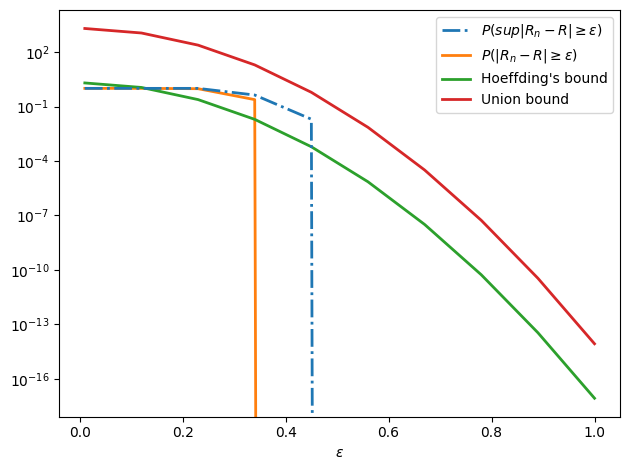

In [10]:
eps_arr = np.linspace(0.01, 1.0, 10)
R, max_P, erm_P = eval(eps_arr)
plot_bounds(max_P, erm_P, eps_arr)